# Задание 2.
Проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. 
Эксперимент проходил с 2023-12-29 по 2024-01-04 включительно. Для эксперимента были задействованы 2 и 1 группы.
В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля.
Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR.
Ваша задача — проанализировать данные А/B-теста. 

Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали именно так? 
Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.
Ваше решение — это ссылка на merge request с проведенным анализом. При выполнении задания важно обосновать и аргументировать ваши ответы и выводы.

### Задачи:
1. Выбрать метод анализа и сравнить CTR в двух группах. Посмотреть на распределения глазами.
2. Описать потенциальную ситуацию, когда такое изменение (увеличение CTR) могло произойти.
3. Написать рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей.

### 1. Подготовка к работе

In [1]:
# загрузка библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandahouse
from scipy import stats
from statsmodels.stats.power import TTestIndPower
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.float_format', '{:.2f}'.format)
import warnings
warnings.simplefilter("ignore")

### 2. Загрузка данных

In [2]:
#параметры соединения - нужны, чтобы подключиться к нужной схеме данных
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20240120',
'user':'student',
'password':'dpo_python_2020'
}

In [3]:
# Запрос к БД
query = '''
SELECT user_id,
       exp_group,
       countIf(user_id, action = 'like' ) as like,
       countIf(user_id, action = 'view' ) as view,
       like/view as ctr
FROM simulator_20240120.feed_actions
WHERE (toDate(time) >= '2023-12-29' AND toDate(time) <= '2024-01-04' 
AND exp_group in [1,2])
GROUP BY user_id, exp_group
'''

# Создание датафрейма
df = pandahouse.read_clickhouse(query, connection=connection)

df

,user_id,exp_group,like,view,ctr
0,109963,1,3,15,0.20
1,26117,1,32,141,0.23
2,138232,1,18,73,0.25
3,18392,1,7,32,0.22
4,26295,1,39,141,0.28
...,...,...,...,...,...
19892,17146,2,0,10,0.00
19893,30872,1,11,59,0.19
19894,25383,2,42,127,0.33
19895,139020,2,17,41,0.41


### 3. Анализ данных

Визуализируем распределение CTR в группах 1 и 2

CTR_mean: 0.216773994120072


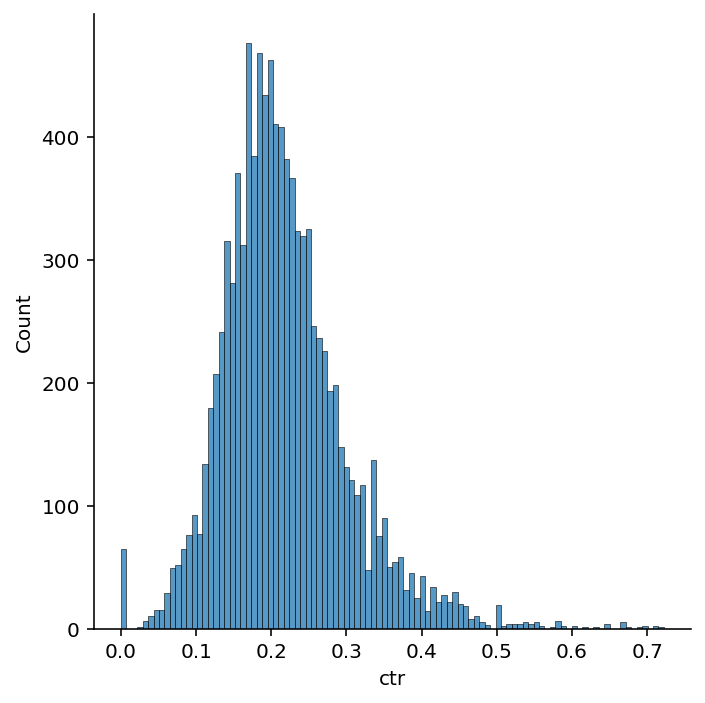

In [4]:
# Распределение экспериментальной группы 1 (контроль)
sns.displot(df[df.exp_group == 1].ctr, kde = False, bins=100);
print('CTR_mean:', df[df.exp_group == 1].ctr.mean())

CTR_mean: 0.2161016893237817


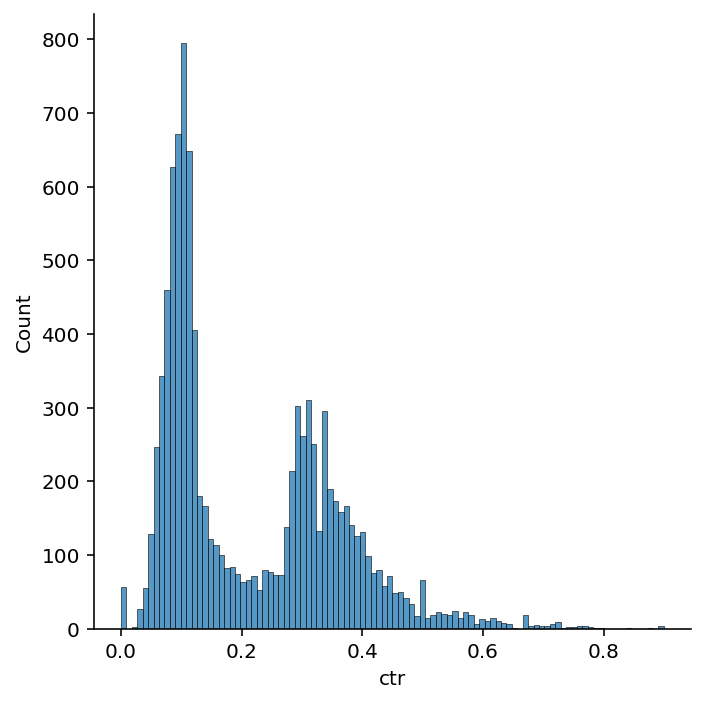

In [5]:
# Распределение экспериментальной группы 2 (тестовая)
sns.displot(df[df.exp_group == 2].ctr, kde = False, bins=100);
print('CTR_mean:', df[df.exp_group == 2].ctr.mean())

При визуальном сравнении 2х распределений можно отметить нормальный характер распределения в контрольной группе, а в тестовой группе наблюдаются два пика в районе 0.1 и в районе 0.3. Значения CTR распределились между двумя этими максимумами возле 0.1 - больше, возле 0.3 - меньше.

**Задача 1. Выбрать метод анализа и сравнить CTR в двух группах.**

Выдвинем гипотезу, что при использовании нового алгоритма в тестовой группе 2, CTR не увеличится.

$\blacktriangleright$ Сформулируем гипотезы:

$H_0:\text{средние значения CTR в контрольной и тестовой группaх равны}$.

$H_1:\text{средние значения CTR в контрольной и тестовой группaх не равны, в контрольной больше}$. 

***Пороговое значение p-value:*** 0.05

Поскольку распределение в тестовой группе не является нормальным, то тесты Манна-Уитни и Т-тест могут давать неверные результаты, но на всякий случай проверим.

**Задача 2.**

**Метод 1.** Использование пользовательского CTR

In [6]:
# Сравнение параметричиским T-тестом
stats.ttest_ind(df[df.exp_group == 1].ctr, df[df.exp_group == 2].ctr, equal_var = False, alternative='greater')

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.3426866655703755)

In [7]:
# Сравнение непараметричиским U-критерием Манна — Уитни
stats.mannwhitneyu(df[df.exp_group == 1].ctr, df[df.exp_group == 2].ctr, alternative='greater')

MannwhitneyuResult(statistic=55189913.0, pvalue=2.316102920903013e-45)

Т-тест показывает p-value значительно > 0.05, что не позволяет нам отвергнуть нулевую гипотезу и принять альтернативную гипотезу.
Тест Манна-Уитни показывает p-value значительно < 0.05, что позволяет нам отвергнуть нулевую гипотезу и принять альтернативную гипотезу.

**Вывод:** По Т-тесту средние значения CTR в экпериментальной группе и контрольной группах могут быть равны для уровня значимости 0.05, а по Манна-Уитни есть вероятность того, что средние значения CTR в экпериментальной группе могут быть меньше, чем в контрольной группе для уровня значимости 0.05.

**Метод 2.** Использование общего CTR, метод bootstrap.

In [8]:
def get_global_ctr(df, exp_group, count_tests = 1000):
    
    """
    функция get_global_ctr использует метод 
    bootstrap для нахождения глобальных CTR
    --------------------
    Параметры:
    df - датафрейм
    exp_group - экспериментальная группа в датафрейме
    count_tests - число проведенных имитаций A/B тестов

    Функция возвращает: 
    pd.Series(glob_ctr_list) - Series из общих CTR
    """
    
    glob_ctr_list = []
    for _ in range(count_tests):
        sample_data = df[df.exp_group == exp_group].sample(frac=0.5, replace=True)
        glob_ctr = sample_data.like.sum() / sample_data.view.sum()
        glob_ctr_list.append(glob_ctr)
    return pd.Series(glob_ctr_list)

In [9]:
# Сохраним полученные bootstrap-распределения CTR в переменные
glob_ctr_group_1 = get_global_ctr(df, 1)
glob_ctr_group_2 = get_global_ctr(df, 2)

Визуализируем распределения общего CTR, полученные используя метод bootstrap

0.20795802211639827 0.20956872275111557 0.21118056883772182


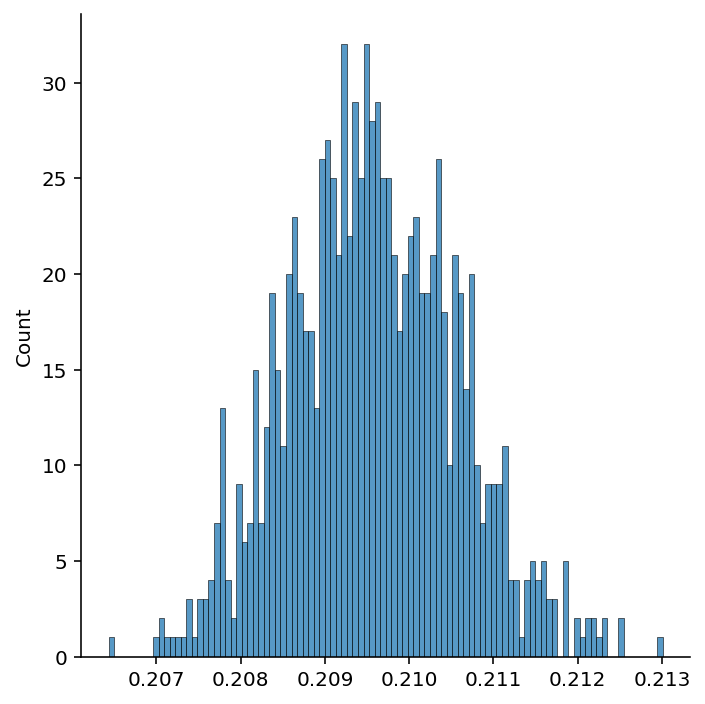

In [10]:
# Распределение группы 1
sns.displot(glob_ctr_group_1, kde = False, bins = 100);
print(glob_ctr_group_1.quantile(0.05),
      glob_ctr_group_1.mean(),
      glob_ctr_group_1.quantile(0.95))

0.1967243750793834 0.2001732239002406 0.2035218011348755


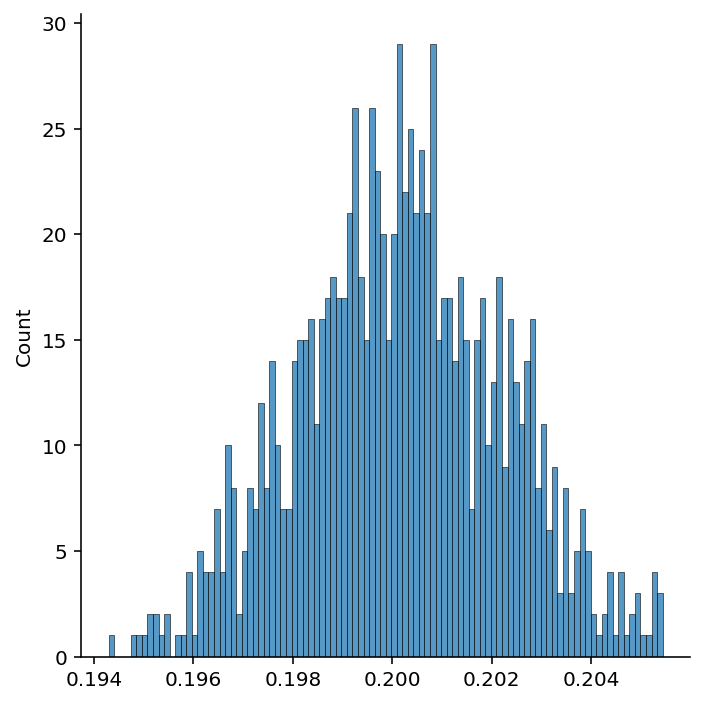

In [11]:
# Распределение группы 2
sns.displot(glob_ctr_group_2, kde = False, bins = 100);
print(glob_ctr_group_2.quantile(0.05),
      glob_ctr_group_2.mean(),
      glob_ctr_group_2.quantile(0.95))

In [12]:
# Сравнение параметричиским T-тестом
stats.ttest_ind(glob_ctr_group_1, glob_ctr_group_2, equal_var = False, alternative='greater')

Ttest_indResult(statistic=130.59182998455395, pvalue=0.0)

In [13]:
# Сравнение непараметричиским U-критерием Манна — Уитни
stats.mannwhitneyu(glob_ctr_group_1, glob_ctr_group_2, alternative='greater')

MannwhitneyuResult(statistic=1000000.0, pvalue=0.0)

In [14]:
# Выборки не пересекаются
print(glob_ctr_group_1.min(), glob_ctr_group_1.max(), glob_ctr_group_1.mean())
print(glob_ctr_group_2.min(), glob_ctr_group_2.max(), glob_ctr_group_2.mean())

0.20643573534600823 0.2130076370371031 0.20956872275111557
0.1942994597626858 0.20543473640101298 0.2001732239002406


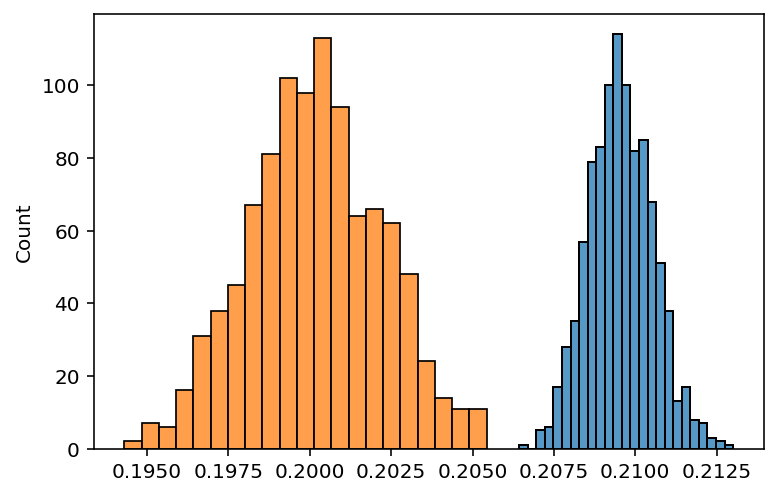

In [15]:
# Построим оба распределения на одной гистограмме
sns.histplot(glob_ctr_group_1)
sns.histplot(glob_ctr_group_2);

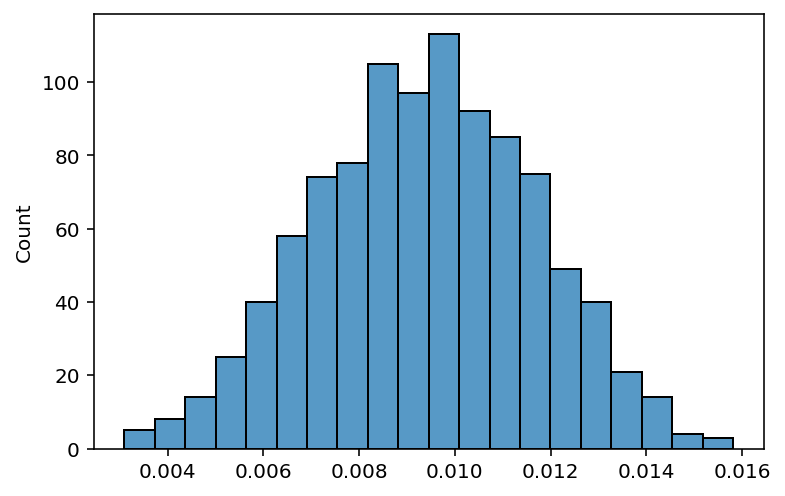

In [16]:
# построим распределение разницы глобального CTR
sns.histplot(glob_ctr_group_1-glob_ctr_group_2);

Используя метод bootstrap мы получили распределения общего CTR для групп 1 и 2. 
Оба критерия однозначно показывают p-value = 0, что не позволяет 
сделать обоснованный вывод, чтобы отвергнуть нулевую гипотезу и принять альтернативную гипотезу. 

**Вывод:** Поскольку p-value = 0 и выборки не пересекаются, а распределение разницы распологается правее 0 и положительно глобальный CTR в контрольной группе больше, чем в экпериментальной группе.

**Метод 3.** Пуассоновский бутстреп для подсчета разницы в CTR

In [17]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    poisson_bootstraps1 = stats.poisson(1).rvs(
                    (n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs(
                    (n_bootstrap, len(likes2))).astype(np.int64)
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)
    return globalCTR1, globalCTR2

In [18]:
likes1 = df[df.exp_group == 1].like.to_numpy()
views1 = df[df.exp_group == 1].view.to_numpy()
likes2 = df[df.exp_group == 2].like.to_numpy()
views2 = df[df.exp_group == 2].view.to_numpy()

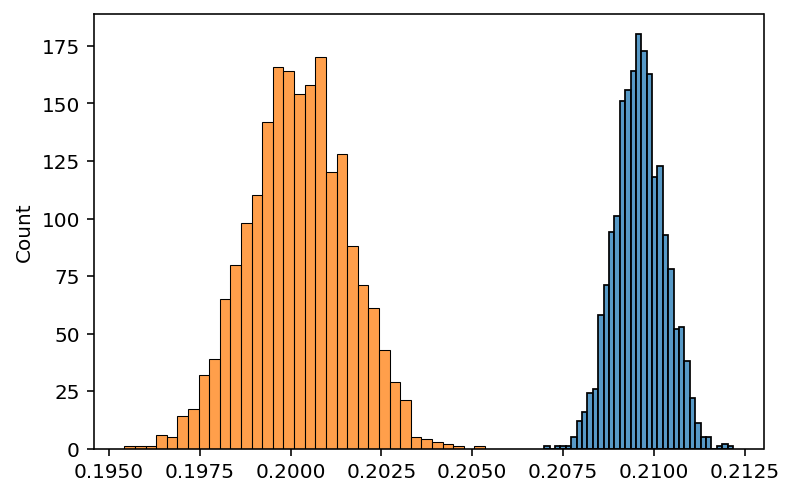

In [19]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)
sns.histplot(ctr1)
sns.histplot(ctr2);

In [20]:
ctr1.mean()

0.20961593172228576

In [21]:
ctr2.mean()

0.20021299695872335

In [22]:
# Разница
diff = ctr1.mean()-ctr2.mean()
diff

0.00940293476356241

Мы видим, что групповой CTR тестовой группы ниже, чем контрольной.

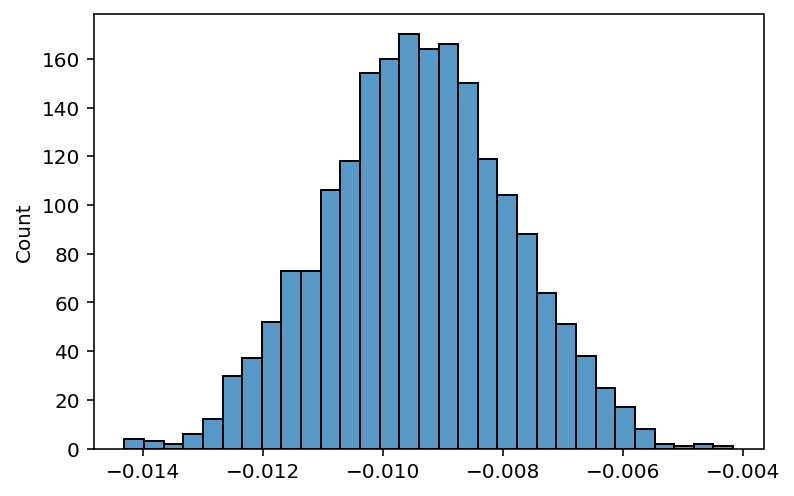

In [23]:
#Разница между глобальными CTR
sns.histplot(ctr2 - ctr1);

Мы видим, что разность не пересекает 0 и имеет отрицательные значения. Это значит, что одна группа строго больше другой. Выходит, что групповой CTR контрольной группы больше,чем тестовой.

**Метод 4.** Бакетный метод. T-тест и тест Манна-Уитни поверх бакетного преобразования.

In [24]:
q = """

SELECT exp_group, 
       bucket,
       sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group, 
             xxHash64(user_id)%50 as bucket,
             user_id,
             countIf(user_id, action = 'like' ) as likes,
             countIf(user_id, action = 'view' ) as views,
             likes/views as ctr
      FROM simulator_20240120.feed_actions 
      WHERE (toDate(time) >= '2023-12-29' AND toDate(time) <= '2024-01-04' 
             and exp_group in [1,2])
      GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket;
"""

df1 = pandahouse.read_clickhouse(q, connection=connection)
df1

,exp_group,bucket,bucket_ctr
0,1,0,0.20
1,2,0,0.20
2,1,1,0.21
3,2,1,0.21
4,1,2,0.20
...,...,...,...
95,2,47,0.20
96,1,48,0.22
97,2,48,0.19
98,1,49,0.21


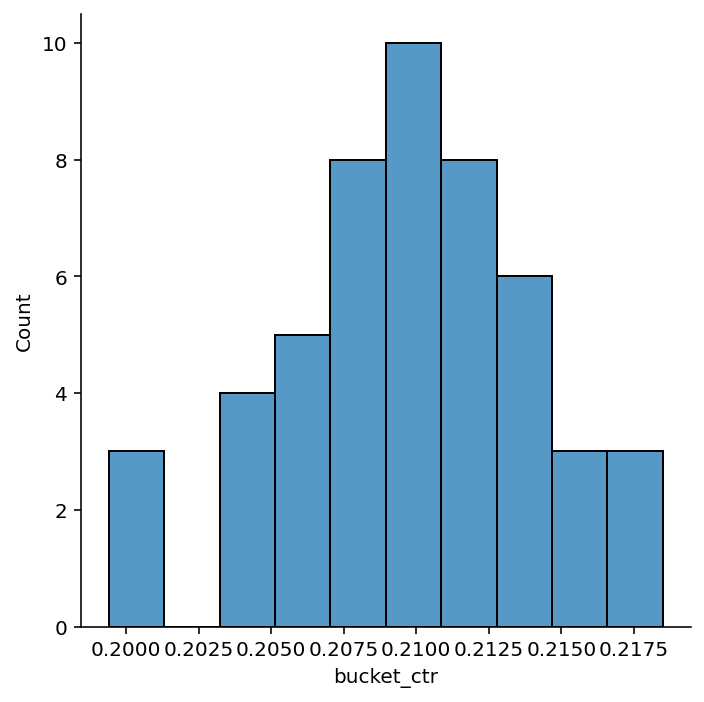

In [25]:
sns.displot(df1[df1.exp_group == 1].bucket_ctr, bins = 10);

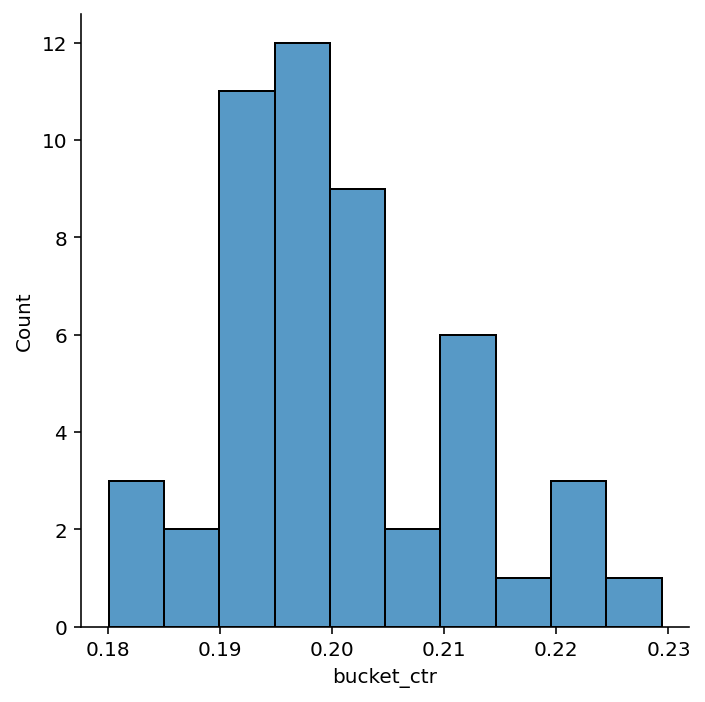

In [26]:
sns.displot(df1[df1.exp_group == 2].bucket_ctr, bins = 10);

In [27]:
#тест Манна-Уитни видит отличие
stats.mannwhitneyu(df1[df1.exp_group == 1].bucket_ctr, 
                   df1[df1.exp_group == 2].bucket_ctr, 
                   alternative='greater')

MannwhitneyuResult(statistic=1997.0, pvalue=1.3288213902005047e-07)

In [28]:
#и t-тест тоже

stats.ttest_ind(df1[df1.exp_group == 1].bucket_ctr, 
                   df1[df1.exp_group == 2].bucket_ctr, 
                   equal_var = False, alternative='greater')

Ttest_indResult(statistic=5.614819358149381, pvalue=2.2963224687369365e-07)

Используя Бакетный метод, T-тест и тест Манна-Уитни поверх бакетного преобразования мы получили распределения бакетного CTR для групп 1 и 2. Визуально CTR в экпериментальной группе - ниже.
Оба критерия однозначно показывают p-value значительно < 0.05, что позволяет 
нам отвергнуть нулевую гипотезу и принять альтернативную гипотезу. 

**Вывод:** средние значения CTR в экпериментальной группе могут быть не равны и меньше контрольной группы для уровня значимости 0.05.

Проверим, что новый алгоритм не привел к тому, что сократилось число просмотров у пользователей.

66.82065868263473


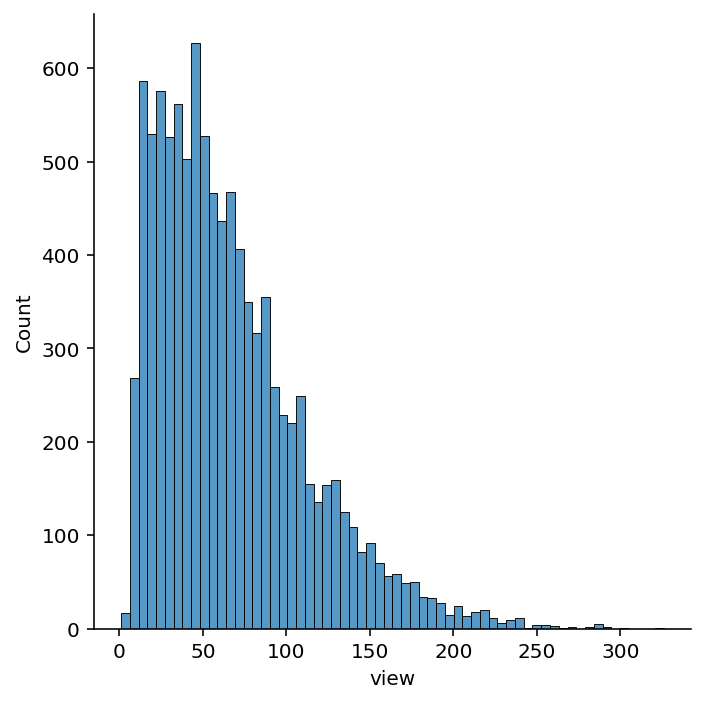

In [29]:
# Распределение просмотров в группе 1
print(df[df.exp_group == 1].view.mean())
sns.displot(df[df.exp_group == 1].view);

66.76662954338362


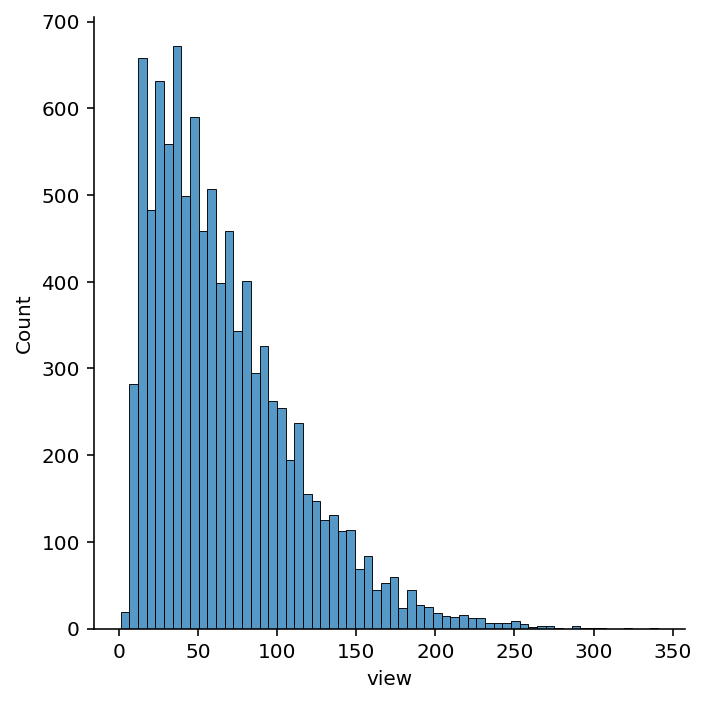

In [30]:
# Распределение просмотров в группе 2
print(df[df.exp_group == 2].view.mean())
sns.displot(df[df.exp_group == 2].view);

Распределение далеко от нормального, поэтому сравнение выборок пока возможно провести только непараметрическими методами. Для возможности работы с таким распределением поможет логарифмирование.

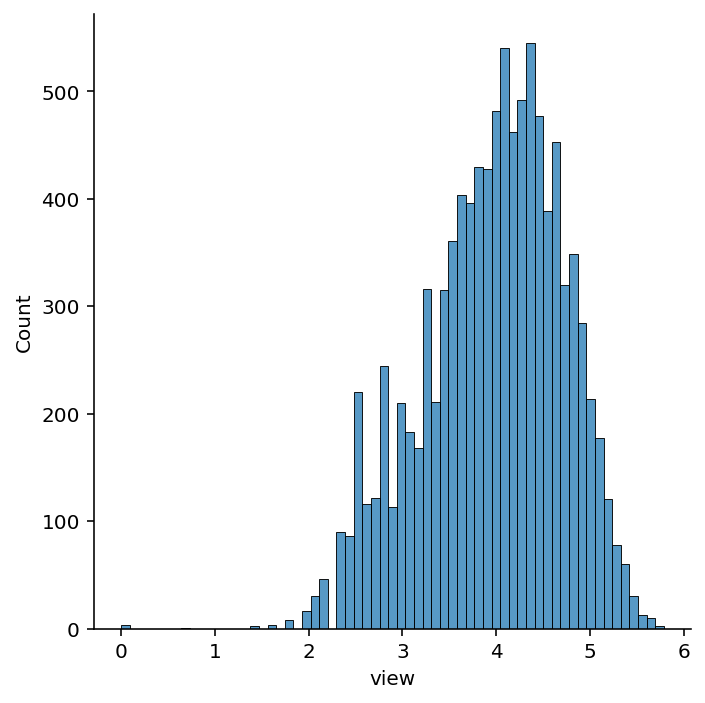

In [31]:
sns.displot(np.log(df[df.exp_group == 1].view));

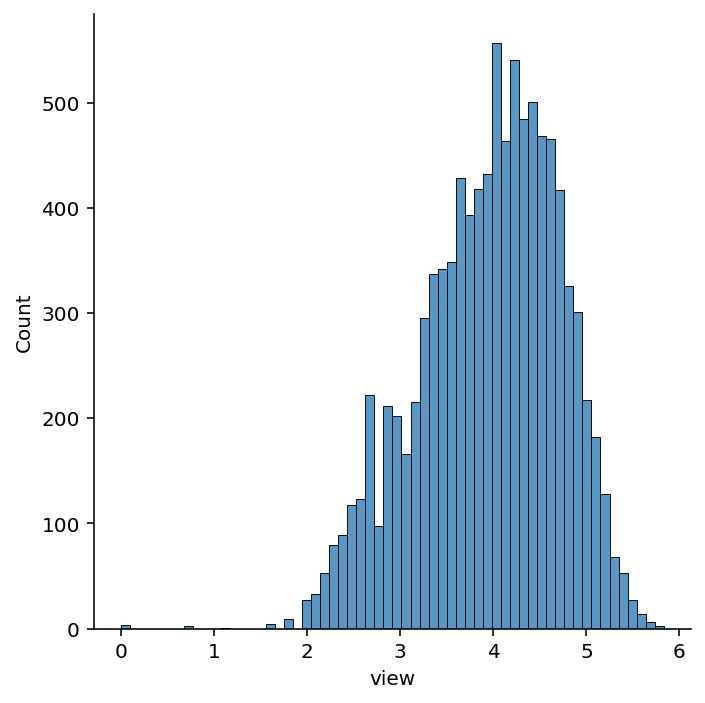

In [32]:
sns.displot(np.log(df[df.exp_group == 2].view));

Распределения в обоих группах стали заметно больше походить на нормальные. Хотя и далеки от идеального, попробуем поработать с ними.

$\blacktriangleright$ Выдвинем новую гипотезу, что в группе 2 в сравнении с группой 1 уменьшилось число просмотров:

$H_0:\text{число просмотров в экспериментальной группе равно числу просмотров в контрольной}$.

$H_1:\text{число просмотров в экспериментальной группе больше, чем в контрольной}$. 

***Пороговое значение p-value:*** 0.05

In [33]:
# Сравнение непараметричиским U-критерием Манна — Уитни
stats.mannwhitneyu(np.log(df[df.exp_group == 1].view), np.log(df[df.exp_group == 2].view), alternative = 'less')

MannwhitneyuResult(statistic=49575968.0, pvalue=0.5900227429840672)

In [34]:
# Сравнение параметричиским T-тестом
stats.ttest_ind(np.log(df[df.exp_group == 1].view), np.log(df[df.exp_group == 2].view), 
                equal_var = False, alternative = 'less')

Ttest_indResult(statistic=0.39136914776041026, pvalue=0.6522357063063101)

Результаты сравнения количества просмотров в группах 1 и 2 критерием Манна-Уитни и t-тестом, со соответствующими значениями p-value, превышающими пороговое значение 0.05, не позволяют отвергнуть нулевую гипотезу. \
**Вывод:** новый алгоритм не привел к снижению количества просмотров в экспериментальной группе.

**Задача 3.**
Почему тесты сработали именно так? Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.

Соберем необходимую информацию по группам 1 и 2

In [35]:
# Информация по группе 1
n_1 = df[df.exp_group == 1].shape[0]
std_1 = np.std(df[df.exp_group == 1].ctr)
mean_1 = np.mean(df[df.exp_group == 1].ctr)
print('n_1:', n_1,'std_1:', std_1, 'mean_1:', mean_1)

n_1: 10020 std_1: 0.08296449184498103 mean_1: 0.216773994120072


In [36]:
# Информация по группе 2
n_2 = df[df.exp_group == 2].shape[0]
std_2 = np.std(df[df.exp_group == 2].ctr)
mean_2 = np.mean(df[df.exp_group == 2].ctr)
print('n_2:', n_2,'std_2:', std_2, 'mean_2:', mean_2)

n_2: 9877 std_2: 0.14286283452772028 mean_2: 0.2161016893237817


In [37]:
ratio = n_2 / n_1
ratio

0.9857285429141717

**При помощи библиотеки метода TTestIndPower попробуем оценить какой размер выборки нам потребуется, при условии:**
* размер эффекта = 0.008,
* мощность эффекта = 0.8
* для сравнения используем t-test 

In [38]:
# Необходимый размер выборки
sample_size = TTestIndPower().solve_power(effect_size = 0.008, power = 0.8, alpha = 0.05, ratio=ratio)
sample_size

247053.43108798563

**Рассчитаем чему оказался равен размер эффекта в нашем проведенном АB-тесте**

In [39]:
# Рассчитаем меру эффекта (стандартизированная средняя разница)
effect_size_AB = (mean_2 - mean_1) / ( ((n_2 - 1) * std_2**2 + (n_1 - 1) * std_1**2) / (n_2 + n_1 - 2) )**0.5
effect_size_AB

-0.005765424969175727

Самые первые тесты сработали по разному, потому что разница средних в наших группах порядка 0.005-0.008 для определения такого эффекта Т - тестом выборка должна быть размером примерно 250 тысяч. Именно поэтому мы наблюдаем такие разные результаты в тестах. Лучше всех сработал в нашем случае бутстреп. 

**Задача 4. Написать рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей.**

### ВЫВОД
По результатам A/B теста, проходившего с 2023-12-29 по 2024-01-04 включительно на группах 1 и 2, был получен статистически значимый, но противоречивый результат: CTR в экспериментальной группе по Т-тесту не увеличилось, по бакетному и бутстреп тесту - уменьшилось. При этом изменение CTR очень маленькое порядка 0.005-0.008. Чувствительности Т - теста оказалось недостаточно для такой разности. Количество просмотров в экспериментальной группе при этом не изменилось. По распределению CTR эспериментальной группы видно, что CTR как бы распределился между двумя группами пользователей, у одних увеличился, у других уменьшился. Раскатывать новый алгоритм в проде на всех пользователей не рекомендую, необходимо провести дополнительные тесты на больших размерах выборок и изучить причины увеличения CTR у определенной группы пользователей.